# Short Strangle with delta hedging

Coming to the reality we can't predict market accurately and it may lead to loss.<br/>
So in practice market neutral strategies are very helpful and can give decent returns with very less risk<br/>
One such strategy is to sell put and call options such that the overall delta of our positions remains 0.

## Importing important libraries

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from datetime import date
from datetime import datetime

import warnings
warnings.filterwarnings("ignore")

# to fetch data 
import yfinance as yf

import scipy.stats as ss

import py_vollib.black_scholes.greeks.analytical as derivatives

import math

## Importing Data

In [2]:
df_call_35000 = pd.read_csv('D:\chrome\OPTIDX_BANKNIFTY_CE_28-May-2021_TO_24-Jun-2021 (1).csv')
df_call_35000.head()

,Symbol,Date,Expiry,Option Type,Strike Price,Open,High,Low,Close,LTP,Settle Price,No. of contracts,Turnover in Lacs,Premium Turnover in Lacs,Open Int,Change in OI,Underlying Value
0,BANKNIFTY,28-May-2021,24-Jun-2021,CE,35000,1394.65,1459.5,1132.0,1213.55,1224.50,1213.55,18138,164479.84,5772.34,283425,39000,35141.45
1,BANKNIFTY,31-May-2021,24-Jun-2021,CE,35000,1197.95,1339.0,1021.6,1308.30,1281.95,1308.30,14456,130864.56,4374.56,245275,-38150,-
2,BANKNIFTY,01-Jun-2021,24-Jun-2021,CE,35000,1291.90,1398.0,1112.3,1155.05,1163.00,1155.05,15231,137967.95,4696.70,345025,99750,-
3,BANKNIFTY,02-Jun-2021,24-Jun-2021,CE,35000,1099.30,1145.7,982.5,1128.05,1122.00,1128.05,12258,110507.46,3249.96,342375,-2650,-
4,BANKNIFTY,03-Jun-2021,24-Jun-2021,CE,35000,1163.20,1342.5,1111.7,1265.45,1270.00,1265.45,7511,68025.76,2304.51,307825,-34550,-


In [3]:
df_put_35000 = pd.read_csv('D:\chrome\OPTIDX_BANKNIFTY_PE_28-May-2021_TO_24-Jun-2021.csv')
df_put_35000.head()

,Symbol,Date,Expiry,Option Type,Strike Price,Open,High,Low,Close,LTP,Settle Price,No. of contracts,Turnover in Lacs,Premium Turnover in Lacs,Open Int,Change in OI,Underlying Value
0,BANKNIFTY,28-May-2021,24-Jun-2021,PE,35000,940.00,984.85,820.20,907.15,856.0,907.15,30957,277944.81,7071.06,217275,-3850,35141.45
1,BANKNIFTY,31-May-2021,24-Jun-2021,PE,35000,886.00,975.50,690.45,706.40,713.9,706.40,22393,200373.31,4434.56,215875,-1400,-
2,BANKNIFTY,01-Jun-2021,24-Jun-2021,PE,35000,682.35,795.25,605.40,701.25,697.0,701.25,22207,198214.51,3903.26,245775,29900,-
3,BANKNIFTY,02-Jun-2021,24-Jun-2021,PE,35000,747.50,799.95,581.80,601.55,587.7,601.55,18375,164002.20,3220.95,235300,-10475,-
4,BANKNIFTY,03-Jun-2021,24-Jun-2021,PE,35000,486.50,564.00,447.15,484.85,489.0,484.85,19913,176748.22,2509.47,217500,-17800,-


In [4]:
symbol = '^NSEBANK'
end = '2021-06-25'
start = '2021-05-28'


# Read data 
df = yf.download(symbol,start,end)

df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-05-28,35345.648438,35436.648438,34977.199219,35141.449219,35141.449219,0
2021-05-31,35097.449219,35584.300781,34930.101562,35526.648438,35526.648438,0
2021-06-01,35639.750000,35713.898438,35241.199219,35337.199219,35337.199219,0
2021-06-02,35271.601562,35415.851562,35070.300781,35373.750000,35373.750000,0
2021-06-03,35536.449219,35723.699219,35413.000000,35649.000000,35649.000000,0


### Calculation of annual volatility and time remaining for expiry used in calculation of delta

In [5]:
symbol = '^NSEBANK'
end = '2021-05-28'
start = '2020-05-28'


# Read data 
df_year = yf.download(symbol,start,end)

df_year.tail()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-05-21,33559.800781,34694.449219,33559.750000,34606.898438,34606.898438,0
2021-05-24,34869.300781,35216.101562,34528.300781,34943.601562,34943.601562,0
2021-05-25,35095.000000,35125.851562,34410.398438,34662.000000,34662.000000,0
2021-05-26,34757.148438,34897.949219,34462.500000,34684.199219,34684.199219,0
2021-05-27,34664.199219,35220.800781,34529.699219,35095.050781,35095.050781,0


In [6]:
def annual_vol(df):
    """
    Function to calculate annual volatility
    
    Parameters
    ----------
    df : dataframe
         Stock info

    Returns
    -------
    vol : float
        annual volatility of the stock
    """
    
    ret = df['Close'].pct_change()[1:] 
    daily_vol = ret.std()
    vol = daily_vol*(252**0.5)
    
    return vol

In [7]:
vol = annual_vol(df_year)
vol

0.2949536683584554

In [10]:
expiry = datetime.strptime('2021-06-24', '%Y-%m-%d')   #Expiry date

In [11]:
time = expiry-df.index    #Time left in days
time

TimedeltaIndex(['27 days', '24 days', '23 days', '22 days', '21 days',
                '20 days', '17 days', '16 days', '15 days', '14 days',
                '13 days', '10 days',  '9 days',  '8 days',  '7 days',
                 '6 days',  '3 days',  '2 days',  '1 days',  '0 days'],
               dtype='timedelta64[ns]', name='Date', freq=None)

In [12]:
time = pd.to_timedelta(time, errors='coerce').days  #Time left in days converted to int data type
time

Int64Index([27, 24, 23, 22, 21, 20, 17, 16, 15, 14, 13, 10, 9, 8, 7, 6, 3, 2,
            1, 0],
           dtype='int64', name='Date')

### Initialising everything required to calculate delta

In [13]:
S = df['Open'][0]    #price of the underlying
K = 35000   #strike price
t = time[0]/365   #time left to expiry in years
sigma = vol   #volatility
r = 0.06  #risk free rate
delta_to_maintain = 0

### Initial selling

In [14]:
no_of_lots_put = 10
sell_avg_put = df_put_35000['Open'][0]
lot_size = 25
delta = derivatives.delta('p', S, K, t, r, sigma)*no_of_lots_put*lot_size

In [15]:
delta

-103.43461645722918

In [16]:
delta_per_lot_call = derivatives.delta('c', S, K, t, r, sigma)*lot_size
delta_per_lot_call

14.656538354277082

In [17]:
no_of_lots_call =  math.ceil((delta_to_maintain - delta)/delta_per_lot_call)
no_of_lots_call

8

In [18]:
sell_avg_call = df_call_35000['Open'][0]
sell_avg_call

1394.65

### Delta Management

In [19]:
number_of_lots_call =  math.ceil((delta_to_maintain - delta)/delta_per_lot_call)
sell_avg_call = df_call_35000['Open'][0]
profit = []
for i in range(len(df)-1):
    delta = derivatives.delta('p', df['Close'][i], K, time[i]/365, r, sigma)*no_of_lots_put*lot_size
    delta_per_lot_call = derivatives.delta('c', df['Close'][i], K, time[i]/365, r, sigma)*lot_size
    current_number_of_lots_call = math.ceil((delta_to_maintain-delta)/delta_per_lot_call)
    no_of_lots_added = current_number_of_lots_call - number_of_lots_call   #number of lots added/subtracted for selling
    sell_avg_call = (sell_avg_call*number_of_lots_call + no_of_lots_added*df_call_35000['Close'][i])/current_number_of_lots_call  #new selling avg of call
    number_of_lots_call = current_number_of_lots_call    #updating number of lots of calls sold
    profit.append((sell_avg_put - df_put_35000['Close'][i])*no_of_lots_put*lot_size + (sell_avg_call-df_call_35000['Close'][i])*lot_size*number_of_lots_call)
    #print(df_put_35000['Close'][i], sell_avg_put, sell_avg_call, df_call_35000['Close'][i], number_of_lots_call)

In [20]:
profit.append((sell_avg_put - df_put_35000['Close'][len(df)-1])*no_of_lots_put*lot_size + (sell_avg_call-df_call_35000['Close'][len(df)-1])*lot_size*number_of_lots_call)

In [21]:
profit

[44432.50000000004,
 75670.00000000004,
 103776.25000000003,
 134101.25000000006,
 139231.25,
 155336.25,
 173938.75000000006,
 204183.75,
 212380.0,
 215035.00000000003,
 239940.0,
 267456.25,
 274581.25,
 281151.25,
 303076.25,
 332570.00000000006,
 369955.0,
 391562.5,
 416448.75,
 522823.75000000006]

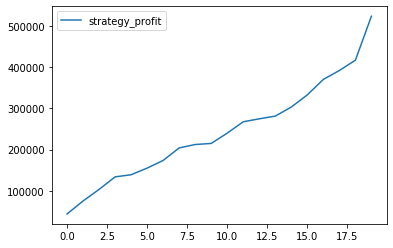

In [22]:
plt.plot(profit, label = 'strategy_profit')
#plt.plot((df_fut['Close']-df_fut['Open'][0])[:14]*250, label = 'futures_profit')
plt.legend()

See the results you get by selling calls and puts and just managing delta at end of day